# Interactive simulation

This notebook is only for designing experiments. Not bulk runs.

In [1]:
print("Hello, world!")

Hello, world!


In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import pandas as pd

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import plotColloid, saveAllPaintedFrames

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Figure configurations

In [4]:
# Figure configurations
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 150

# Setup

In [5]:
sp = ice.spins()

# Initialize some parameters
trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 120*ureg.s

L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = particleRadius,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
               height = 4*ureg.pN*ureg.nm,
               stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap,
                        height_spread = 0, 
                        susceptibility_spread = 0.1,
                        periodic = True)

# Plotting for sanity check
#f, (ax1,ax2) = plt.subplots(1,2,figsize = (7,3.5))
#sp.display(ax1)
#col.display(ax2)

In [6]:
# Fix boundaries

col.randomize()
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

#f, (ax2) = plt.subplots(1,1,figsize = (3,3))
#col.display(ax2)

In [8]:
# Prepare the simulation
framespersec = 10*ureg.Hz;
dt = 10*ureg.ms

world = ice.world(
    field = 5*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)


col.simulation(world,
             name = "test",
             include_timestamp = False,
             targetdir = r".",
             framerate = framespersec,
             timestep = dt,
             run_time = totalTime,
             output = ["x","y","z","mux","muy","muz"])

In [10]:
# Field design

col.sim.field.fieldx = "v_Bmag*sin(PI/3)*time/60e6*(time<60e6)+v_Bmag*sin(PI/3)*(time>=60e6)"
col.sim.field.fieldy = "0"
col.sim.field.fieldz = "v_Bmag*cos(PI/3)*time/60e6*(time<60e6)+v_Bmag*cos(PI/3)*(time>=60e6)"


col.run_simulation()

## Saving stuff

In [11]:
col.load_simulation()
col.trj.to_csv('../data/trj.csv')
print('Saved trj')
trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
trj.to_csv('../data/ctrj.csv')
print('Saved ctrj')

scanning file


  0%|          | 0/19677125 [00:00<?, ?it/s]

Saved trj
Saved ctrj


# Animation (In case it is needed)

In [11]:
anim = col.animate(sl=slice(0,-1,10),speed=10)
anim.save("60deg_ramp5mT60s_evo60s.gif",writer = "imagemagick")

MovieWriter imagemagick unavailable; using Pillow instead.


# Analysis and Vertex Counting

## Field Sanity Check

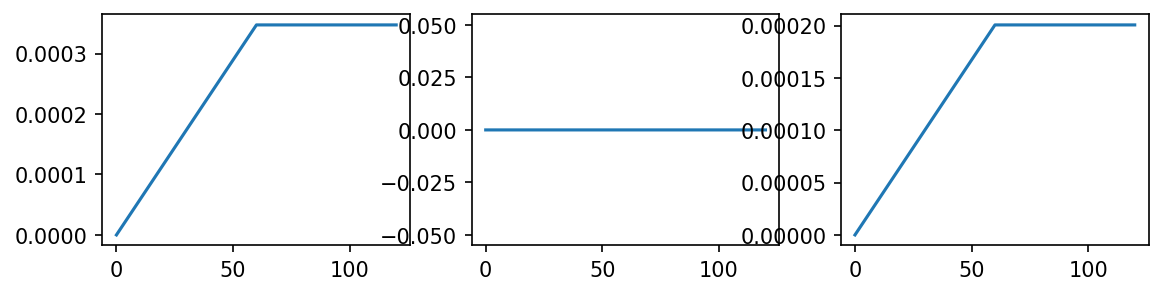

In [9]:
trj_raw = trj = pd.read_csv("../data/trj.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/ctrj.csv", index_col=[0,1])

fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax[0].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax[1].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax[2].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))


## Trajectories sanity check

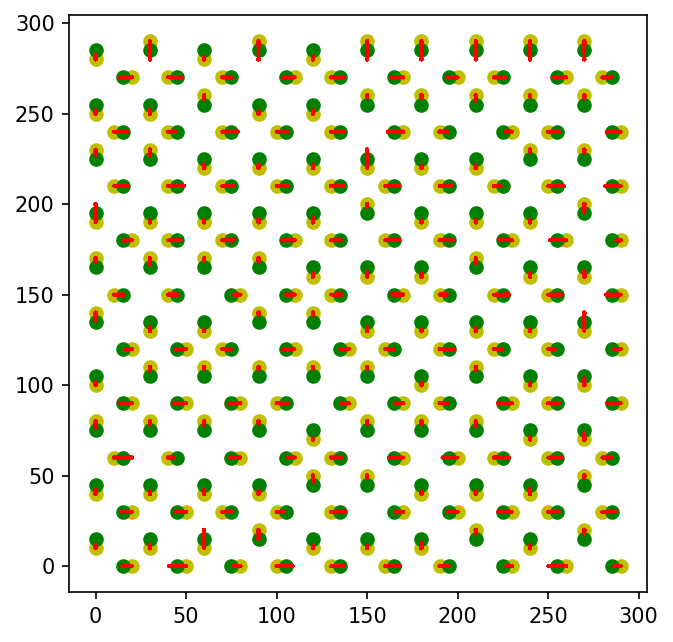

In [10]:
f,ax = plotColloid(trj_raw,0);
for i, trj_i in trj_raw.groupby("id"):
    if all(trj_i.type==1):
        ax.plot(np.array(trj_i.x),np.array(trj_i.y), color = "r")

## Vertex Charges

In [15]:
path = "../data/test3/paintedFrames/"
frames = trj.index.get_level_values("frame").unique().to_list();
frames = frames[:];
saveAllPaintedFrames(trj_raw,ctrj_raw,
                     frames,framespersec.magnitude,
                     path);

100%|██████████| 200/200 [00:01<00:00, 163.49it/s]


0


100%|██████████| 200/200 [00:01<00:00, 142.87it/s]


1


100%|██████████| 200/200 [00:01<00:00, 153.77it/s]


2


100%|██████████| 200/200 [00:01<00:00, 162.38it/s]


3


100%|██████████| 200/200 [00:01<00:00, 155.99it/s]


4


100%|██████████| 200/200 [00:01<00:00, 154.23it/s]


5


100%|██████████| 200/200 [00:01<00:00, 161.30it/s]


6


100%|██████████| 200/200 [00:01<00:00, 158.35it/s]


7


100%|██████████| 200/200 [00:01<00:00, 155.64it/s]


8


100%|██████████| 200/200 [00:01<00:00, 161.90it/s]


9


100%|██████████| 200/200 [00:01<00:00, 158.10it/s]


10


100%|██████████| 200/200 [00:01<00:00, 156.11it/s]


11


100%|██████████| 200/200 [00:01<00:00, 161.40it/s]


12


100%|██████████| 200/200 [00:01<00:00, 160.90it/s]


13


100%|██████████| 200/200 [00:01<00:00, 152.98it/s]


14


100%|██████████| 200/200 [00:01<00:00, 144.16it/s]


15


100%|██████████| 200/200 [00:01<00:00, 159.35it/s]


16


100%|██████████| 200/200 [00:01<00:00, 147.38it/s]


17


100%|██████████| 200/200 [00:01<00:00, 161.78it/s]


18


100%|██████████| 200/200 [00:01<00:00, 152.16it/s]


19


100%|██████████| 200/200 [00:01<00:00, 160.13it/s]


20


100%|██████████| 200/200 [00:01<00:00, 155.62it/s]


21


100%|██████████| 200/200 [00:01<00:00, 151.00it/s]


22


100%|██████████| 200/200 [00:01<00:00, 153.24it/s]


23


100%|██████████| 200/200 [00:01<00:00, 155.71it/s]


24


100%|██████████| 200/200 [00:01<00:00, 145.12it/s]


25


100%|██████████| 200/200 [00:01<00:00, 160.80it/s]


26


100%|██████████| 200/200 [00:01<00:00, 163.13it/s]


27


100%|██████████| 200/200 [00:01<00:00, 149.47it/s]


28


100%|██████████| 200/200 [00:01<00:00, 146.18it/s]


29


100%|██████████| 200/200 [00:01<00:00, 153.25it/s]


30


100%|██████████| 200/200 [00:01<00:00, 155.97it/s]


31


100%|██████████| 200/200 [00:01<00:00, 152.98it/s]


32


100%|██████████| 200/200 [00:01<00:00, 152.27it/s]


33


100%|██████████| 200/200 [00:01<00:00, 150.60it/s]


34


100%|██████████| 200/200 [00:01<00:00, 157.93it/s]


35


100%|██████████| 200/200 [00:01<00:00, 136.46it/s]


36


100%|██████████| 200/200 [00:01<00:00, 164.57it/s]


37


100%|██████████| 200/200 [00:01<00:00, 160.87it/s]


38


100%|██████████| 200/200 [00:01<00:00, 164.49it/s]


39


100%|██████████| 200/200 [00:01<00:00, 162.83it/s]


40


100%|██████████| 200/200 [00:01<00:00, 140.89it/s]


41


100%|██████████| 200/200 [00:01<00:00, 141.92it/s]


42


100%|██████████| 200/200 [00:01<00:00, 151.40it/s]


43


100%|██████████| 200/200 [00:01<00:00, 135.49it/s]


44


100%|██████████| 200/200 [00:01<00:00, 159.98it/s]


45


100%|██████████| 200/200 [00:01<00:00, 130.32it/s]


46


100%|██████████| 200/200 [00:01<00:00, 133.63it/s]


47


100%|██████████| 200/200 [00:01<00:00, 136.97it/s]


48


100%|██████████| 200/200 [00:01<00:00, 128.22it/s]


49


100%|██████████| 200/200 [00:01<00:00, 126.42it/s]


50


100%|██████████| 200/200 [00:01<00:00, 141.15it/s]


51


100%|██████████| 200/200 [00:01<00:00, 123.87it/s]


52


100%|██████████| 200/200 [00:01<00:00, 130.60it/s]


53


100%|██████████| 200/200 [00:01<00:00, 143.11it/s]


54


100%|██████████| 200/200 [00:01<00:00, 138.26it/s]


55


100%|██████████| 200/200 [00:01<00:00, 157.18it/s]


56


100%|██████████| 200/200 [00:01<00:00, 140.75it/s]


57


100%|██████████| 200/200 [00:01<00:00, 159.30it/s]


58


100%|██████████| 200/200 [00:01<00:00, 154.72it/s]


59


100%|██████████| 200/200 [00:01<00:00, 166.97it/s]


60


100%|██████████| 200/200 [00:01<00:00, 155.83it/s]


61


100%|██████████| 200/200 [00:01<00:00, 157.92it/s]


62


100%|██████████| 200/200 [00:01<00:00, 158.18it/s]


63


100%|██████████| 200/200 [00:01<00:00, 154.34it/s]


64


100%|██████████| 200/200 [00:01<00:00, 152.00it/s]


65


100%|██████████| 200/200 [00:01<00:00, 162.35it/s]


66


100%|██████████| 200/200 [00:01<00:00, 153.32it/s]


67


100%|██████████| 200/200 [00:01<00:00, 154.78it/s]


68


100%|██████████| 200/200 [00:01<00:00, 153.77it/s]


69


100%|██████████| 200/200 [00:01<00:00, 153.90it/s]


70


100%|██████████| 200/200 [00:01<00:00, 163.22it/s]


71


100%|██████████| 200/200 [00:01<00:00, 157.06it/s]


72


100%|██████████| 200/200 [00:01<00:00, 151.93it/s]


73


100%|██████████| 200/200 [00:01<00:00, 154.29it/s]


74


100%|██████████| 200/200 [00:01<00:00, 155.21it/s]


75


100%|██████████| 200/200 [00:01<00:00, 148.56it/s]


76


100%|██████████| 200/200 [00:01<00:00, 155.78it/s]


77


100%|██████████| 200/200 [00:01<00:00, 154.12it/s]


78


100%|██████████| 200/200 [00:01<00:00, 156.77it/s]


79


100%|██████████| 200/200 [00:01<00:00, 161.19it/s]


80


100%|██████████| 200/200 [00:01<00:00, 152.93it/s]


81


100%|██████████| 200/200 [00:01<00:00, 165.53it/s]


82


100%|██████████| 200/200 [00:01<00:00, 151.19it/s]


83


100%|██████████| 200/200 [00:01<00:00, 155.18it/s]


84


100%|██████████| 200/200 [00:01<00:00, 146.44it/s]


85


100%|██████████| 200/200 [00:01<00:00, 153.69it/s]


86


100%|██████████| 200/200 [00:01<00:00, 155.30it/s]


87


100%|██████████| 200/200 [00:01<00:00, 151.15it/s]


88


100%|██████████| 200/200 [00:01<00:00, 156.43it/s]


89


100%|██████████| 200/200 [00:01<00:00, 150.59it/s]


90


100%|██████████| 200/200 [00:01<00:00, 155.76it/s]


91


100%|██████████| 200/200 [00:01<00:00, 155.05it/s]


92


100%|██████████| 200/200 [00:01<00:00, 155.19it/s]


93


100%|██████████| 200/200 [00:01<00:00, 154.14it/s]


94


100%|██████████| 200/200 [00:01<00:00, 149.22it/s]


95


100%|██████████| 200/200 [00:01<00:00, 153.82it/s]


96


100%|██████████| 200/200 [00:01<00:00, 157.34it/s]


97


100%|██████████| 200/200 [00:01<00:00, 148.68it/s]


98


100%|██████████| 200/200 [00:01<00:00, 156.37it/s]


99


100%|██████████| 200/200 [00:01<00:00, 157.87it/s]


100


100%|██████████| 200/200 [00:01<00:00, 161.61it/s]


101


100%|██████████| 200/200 [00:01<00:00, 157.34it/s]


102


100%|██████████| 200/200 [00:01<00:00, 158.50it/s]


103


100%|██████████| 200/200 [00:01<00:00, 166.89it/s]


104


100%|██████████| 200/200 [00:01<00:00, 154.78it/s]


105


100%|██████████| 200/200 [00:01<00:00, 144.18it/s]


106


100%|██████████| 200/200 [00:01<00:00, 154.03it/s]


107


100%|██████████| 200/200 [00:01<00:00, 152.01it/s]


108


100%|██████████| 200/200 [00:01<00:00, 154.30it/s]


109


100%|██████████| 200/200 [00:01<00:00, 160.09it/s]


110


100%|██████████| 200/200 [00:01<00:00, 153.41it/s]


111


100%|██████████| 200/200 [00:01<00:00, 156.43it/s]


112


100%|██████████| 200/200 [00:01<00:00, 133.27it/s]


113


100%|██████████| 200/200 [00:01<00:00, 160.27it/s]


114


100%|██████████| 200/200 [00:01<00:00, 162.16it/s]


115


100%|██████████| 200/200 [00:01<00:00, 167.59it/s]


116


100%|██████████| 200/200 [00:01<00:00, 164.96it/s]


117


100%|██████████| 200/200 [00:01<00:00, 163.23it/s]


118


100%|██████████| 200/200 [00:01<00:00, 144.63it/s]


119


100%|██████████| 200/200 [00:01<00:00, 164.21it/s]


120


100%|██████████| 200/200 [00:01<00:00, 158.05it/s]


121


100%|██████████| 200/200 [00:01<00:00, 173.74it/s]


122


100%|██████████| 200/200 [00:01<00:00, 156.00it/s]


123


100%|██████████| 200/200 [00:01<00:00, 182.24it/s]


124


100%|██████████| 200/200 [00:01<00:00, 155.51it/s]


125


100%|██████████| 200/200 [00:01<00:00, 156.03it/s]


126


100%|██████████| 200/200 [00:01<00:00, 159.13it/s]


127


100%|██████████| 200/200 [00:01<00:00, 149.78it/s]


128


100%|██████████| 200/200 [00:01<00:00, 163.10it/s]


129


100%|██████████| 200/200 [00:01<00:00, 162.31it/s]


130


100%|██████████| 200/200 [00:01<00:00, 156.92it/s]


131


100%|██████████| 200/200 [00:01<00:00, 152.70it/s]


132


100%|██████████| 200/200 [00:01<00:00, 149.74it/s]


133


100%|██████████| 200/200 [00:01<00:00, 159.37it/s]


134


100%|██████████| 200/200 [00:01<00:00, 156.03it/s]


135


100%|██████████| 200/200 [00:01<00:00, 154.31it/s]


136


100%|██████████| 200/200 [00:01<00:00, 153.79it/s]


137


100%|██████████| 200/200 [00:01<00:00, 151.84it/s]


138


100%|██████████| 200/200 [00:01<00:00, 158.45it/s]


139


100%|██████████| 200/200 [00:01<00:00, 142.23it/s]


140


100%|██████████| 200/200 [00:01<00:00, 151.59it/s]


141


100%|██████████| 200/200 [00:01<00:00, 154.31it/s]


142


100%|██████████| 200/200 [00:01<00:00, 157.91it/s]


143


100%|██████████| 200/200 [00:01<00:00, 149.75it/s]


144


100%|██████████| 200/200 [00:01<00:00, 160.50it/s]


145


100%|██████████| 200/200 [00:01<00:00, 151.02it/s]


146


100%|██████████| 200/200 [00:01<00:00, 149.29it/s]


147


100%|██████████| 200/200 [00:01<00:00, 161.39it/s]


148


100%|██████████| 200/200 [00:01<00:00, 148.39it/s]


149


100%|██████████| 200/200 [00:01<00:00, 152.92it/s]


150


100%|██████████| 200/200 [00:01<00:00, 152.03it/s]


151


100%|██████████| 200/200 [00:01<00:00, 155.06it/s]


152


100%|██████████| 200/200 [00:01<00:00, 152.39it/s]


153


100%|██████████| 200/200 [00:01<00:00, 154.36it/s]


154


100%|██████████| 200/200 [00:01<00:00, 148.47it/s]


155


100%|██████████| 200/200 [00:01<00:00, 156.45it/s]


156


100%|██████████| 200/200 [00:01<00:00, 150.31it/s]


157


100%|██████████| 200/200 [00:01<00:00, 148.02it/s]


158


100%|██████████| 200/200 [00:01<00:00, 155.21it/s]


159


100%|██████████| 200/200 [00:01<00:00, 153.96it/s]


160


100%|██████████| 200/200 [00:01<00:00, 153.98it/s]


161


100%|██████████| 200/200 [00:01<00:00, 153.23it/s]


162


100%|██████████| 200/200 [00:01<00:00, 155.87it/s]


163


100%|██████████| 200/200 [00:01<00:00, 150.17it/s]


164


100%|██████████| 200/200 [00:01<00:00, 154.74it/s]


165


100%|██████████| 200/200 [00:01<00:00, 142.50it/s]


166


100%|██████████| 200/200 [00:01<00:00, 156.13it/s]


167


100%|██████████| 200/200 [00:01<00:00, 151.51it/s]


168


100%|██████████| 200/200 [00:01<00:00, 158.02it/s]


169


100%|██████████| 200/200 [00:01<00:00, 152.27it/s]


170


100%|██████████| 200/200 [00:01<00:00, 154.63it/s]


171


100%|██████████| 200/200 [00:01<00:00, 155.51it/s]


172


100%|██████████| 200/200 [00:01<00:00, 150.50it/s]


173


100%|██████████| 200/200 [00:01<00:00, 157.92it/s]


174


100%|██████████| 200/200 [00:01<00:00, 150.54it/s]


175


100%|██████████| 200/200 [00:01<00:00, 154.01it/s]


176


100%|██████████| 200/200 [00:01<00:00, 157.97it/s]


177


100%|██████████| 200/200 [00:01<00:00, 160.73it/s]


178


100%|██████████| 200/200 [00:01<00:00, 152.00it/s]


179


100%|██████████| 200/200 [00:01<00:00, 155.65it/s]


180


100%|██████████| 200/200 [00:01<00:00, 156.55it/s]


181


100%|██████████| 200/200 [00:01<00:00, 151.71it/s]


182


100%|██████████| 200/200 [00:01<00:00, 150.46it/s]


183


100%|██████████| 200/200 [00:01<00:00, 157.33it/s]


184


100%|██████████| 200/200 [00:01<00:00, 162.42it/s]


185


100%|██████████| 200/200 [00:01<00:00, 157.07it/s]


186


100%|██████████| 200/200 [00:01<00:00, 143.70it/s]


187


100%|██████████| 200/200 [00:01<00:00, 147.99it/s]


188


100%|██████████| 200/200 [00:01<00:00, 151.62it/s]


189


100%|██████████| 200/200 [00:01<00:00, 156.84it/s]


190


100%|██████████| 200/200 [00:01<00:00, 150.44it/s]


191


100%|██████████| 200/200 [00:01<00:00, 155.05it/s]


192


100%|██████████| 200/200 [00:01<00:00, 154.50it/s]


193


100%|██████████| 200/200 [00:01<00:00, 150.45it/s]


194


100%|██████████| 200/200 [00:01<00:00, 147.94it/s]


195


100%|██████████| 200/200 [00:01<00:00, 147.46it/s]


196


100%|██████████| 200/200 [00:01<00:00, 152.58it/s]


197


100%|██████████| 200/200 [00:01<00:00, 147.38it/s]


198


100%|██████████| 200/200 [00:01<00:00, 158.59it/s]


199


100%|██████████| 200/200 [00:01<00:00, 148.68it/s]


200


100%|██████████| 200/200 [00:01<00:00, 148.92it/s]


201


100%|██████████| 200/200 [00:01<00:00, 161.03it/s]


202


100%|██████████| 200/200 [00:01<00:00, 152.16it/s]


203


100%|██████████| 200/200 [00:01<00:00, 145.89it/s]


204


100%|██████████| 200/200 [00:01<00:00, 153.29it/s]


205


100%|██████████| 200/200 [00:01<00:00, 151.27it/s]


206


100%|██████████| 200/200 [00:01<00:00, 155.19it/s]


207


100%|██████████| 200/200 [00:01<00:00, 153.89it/s]


208


100%|██████████| 200/200 [00:01<00:00, 154.48it/s]


209


100%|██████████| 200/200 [00:01<00:00, 147.40it/s]


210


100%|██████████| 200/200 [00:01<00:00, 144.71it/s]


211


100%|██████████| 200/200 [00:01<00:00, 150.25it/s]


212


100%|██████████| 200/200 [00:01<00:00, 156.36it/s]


213


100%|██████████| 200/200 [00:01<00:00, 152.31it/s]


214


100%|██████████| 200/200 [00:01<00:00, 147.29it/s]


215


100%|██████████| 200/200 [00:01<00:00, 151.82it/s]


216


100%|██████████| 200/200 [00:01<00:00, 143.68it/s]


217


100%|██████████| 200/200 [00:01<00:00, 161.94it/s]


218


100%|██████████| 200/200 [00:01<00:00, 148.95it/s]


219


100%|██████████| 200/200 [00:01<00:00, 146.53it/s]


220


100%|██████████| 200/200 [00:01<00:00, 148.51it/s]


221


100%|██████████| 200/200 [00:01<00:00, 147.41it/s]


222


100%|██████████| 200/200 [00:01<00:00, 148.77it/s]


223


100%|██████████| 200/200 [00:01<00:00, 147.20it/s]


224


100%|██████████| 200/200 [00:01<00:00, 156.07it/s]


225


100%|██████████| 200/200 [00:01<00:00, 153.58it/s]


226


100%|██████████| 200/200 [00:01<00:00, 145.04it/s]


227


100%|██████████| 200/200 [00:01<00:00, 150.81it/s]


228


100%|██████████| 200/200 [00:01<00:00, 148.79it/s]


229


100%|██████████| 200/200 [00:01<00:00, 153.19it/s]


230


100%|██████████| 200/200 [00:01<00:00, 151.57it/s]


231


100%|██████████| 200/200 [00:01<00:00, 158.74it/s]


232


100%|██████████| 200/200 [00:01<00:00, 143.48it/s]


233


100%|██████████| 200/200 [00:01<00:00, 150.17it/s]


234


100%|██████████| 200/200 [00:01<00:00, 147.29it/s]


235


100%|██████████| 200/200 [00:01<00:00, 155.13it/s]


236


100%|██████████| 200/200 [00:01<00:00, 146.84it/s]


237


100%|██████████| 200/200 [00:01<00:00, 145.75it/s]


238


100%|██████████| 200/200 [00:01<00:00, 153.71it/s]


239


100%|██████████| 200/200 [00:01<00:00, 150.50it/s]


240


100%|██████████| 200/200 [00:01<00:00, 143.31it/s]


241


100%|██████████| 200/200 [00:01<00:00, 150.01it/s]


242


100%|██████████| 200/200 [00:01<00:00, 147.99it/s]


243


100%|██████████| 200/200 [00:01<00:00, 144.83it/s]


244


100%|██████████| 200/200 [00:01<00:00, 149.75it/s]


245


100%|██████████| 200/200 [00:01<00:00, 152.21it/s]


246


100%|██████████| 200/200 [00:01<00:00, 152.90it/s]


247


100%|██████████| 200/200 [00:01<00:00, 144.45it/s]


248


100%|██████████| 200/200 [00:01<00:00, 155.82it/s]


249


100%|██████████| 200/200 [00:01<00:00, 170.98it/s]


250


100%|██████████| 200/200 [00:01<00:00, 175.89it/s]


251


100%|██████████| 200/200 [00:01<00:00, 173.67it/s]


252


100%|██████████| 200/200 [00:01<00:00, 174.07it/s]


253


100%|██████████| 200/200 [00:01<00:00, 184.26it/s]


254


100%|██████████| 200/200 [00:01<00:00, 197.84it/s]


255


100%|██████████| 200/200 [00:01<00:00, 176.06it/s]


256


100%|██████████| 200/200 [00:01<00:00, 184.40it/s]


257


100%|██████████| 200/200 [00:01<00:00, 181.21it/s]


258


100%|██████████| 200/200 [00:01<00:00, 198.97it/s]


259


100%|██████████| 200/200 [00:01<00:00, 170.34it/s]


260


100%|██████████| 200/200 [00:01<00:00, 167.50it/s]


261


100%|██████████| 200/200 [00:01<00:00, 175.61it/s]


262


100%|██████████| 200/200 [00:01<00:00, 182.47it/s]


263


100%|██████████| 200/200 [00:01<00:00, 185.74it/s]


264


100%|██████████| 200/200 [00:01<00:00, 183.81it/s]


265


100%|██████████| 200/200 [00:01<00:00, 191.43it/s]


266


100%|██████████| 200/200 [00:01<00:00, 165.97it/s]


267


100%|██████████| 200/200 [00:01<00:00, 179.49it/s]


268


100%|██████████| 200/200 [00:01<00:00, 179.58it/s]


269


100%|██████████| 200/200 [00:01<00:00, 181.34it/s]


270


100%|██████████| 200/200 [00:01<00:00, 199.48it/s]


271


100%|██████████| 200/200 [00:00<00:00, 204.50it/s]


272


100%|██████████| 200/200 [00:01<00:00, 188.22it/s]


273


100%|██████████| 200/200 [00:01<00:00, 180.78it/s]


274


100%|██████████| 200/200 [00:01<00:00, 178.13it/s]


275


100%|██████████| 200/200 [00:01<00:00, 184.61it/s]


276


100%|██████████| 200/200 [00:01<00:00, 180.02it/s]


277


100%|██████████| 200/200 [00:01<00:00, 182.85it/s]


278


100%|██████████| 200/200 [00:01<00:00, 182.18it/s]


279


100%|██████████| 200/200 [00:01<00:00, 186.51it/s]


280


100%|██████████| 200/200 [00:01<00:00, 184.93it/s]


281


100%|██████████| 200/200 [00:01<00:00, 183.66it/s]


282


100%|██████████| 200/200 [00:01<00:00, 179.14it/s]


283


100%|██████████| 200/200 [00:01<00:00, 181.72it/s]


284


100%|██████████| 200/200 [00:01<00:00, 178.47it/s]


285


100%|██████████| 200/200 [00:02<00:00, 92.88it/s] 


286


100%|██████████| 200/200 [00:02<00:00, 84.45it/s] 


287


100%|██████████| 200/200 [00:01<00:00, 131.22it/s]


288


100%|██████████| 200/200 [00:01<00:00, 193.49it/s]


289


100%|██████████| 200/200 [00:01<00:00, 179.81it/s]


290


100%|██████████| 200/200 [00:01<00:00, 177.71it/s]


291


100%|██████████| 200/200 [00:01<00:00, 178.81it/s]


292


100%|██████████| 200/200 [00:01<00:00, 162.47it/s]


293


100%|██████████| 200/200 [00:01<00:00, 158.36it/s]


294


100%|██████████| 200/200 [00:01<00:00, 159.66it/s]


295


100%|██████████| 200/200 [00:01<00:00, 181.02it/s]


296


100%|██████████| 200/200 [00:01<00:00, 180.94it/s]


297


100%|██████████| 200/200 [00:01<00:00, 170.56it/s]


298


100%|██████████| 200/200 [00:01<00:00, 145.90it/s]


299


100%|██████████| 200/200 [00:01<00:00, 151.91it/s]


300


100%|██████████| 200/200 [00:01<00:00, 181.23it/s]


301


100%|██████████| 200/200 [00:01<00:00, 187.35it/s]


302


100%|██████████| 200/200 [00:01<00:00, 156.26it/s]


303


100%|██████████| 200/200 [00:01<00:00, 190.37it/s]


304


100%|██████████| 200/200 [00:01<00:00, 191.51it/s]


305


100%|██████████| 200/200 [00:01<00:00, 169.03it/s]


306


100%|██████████| 200/200 [00:01<00:00, 171.33it/s]


307


100%|██████████| 200/200 [00:01<00:00, 163.82it/s]


308


100%|██████████| 200/200 [00:01<00:00, 179.72it/s]


309


100%|██████████| 200/200 [00:01<00:00, 171.61it/s]


310


100%|██████████| 200/200 [00:02<00:00, 98.65it/s] 


311


100%|██████████| 200/200 [00:01<00:00, 155.06it/s]


312


100%|██████████| 200/200 [00:01<00:00, 185.01it/s]


313


100%|██████████| 200/200 [00:01<00:00, 174.64it/s]


314


100%|██████████| 200/200 [00:01<00:00, 182.56it/s]


315


100%|██████████| 200/200 [00:01<00:00, 150.75it/s]


316


100%|██████████| 200/200 [00:01<00:00, 168.93it/s]


317


100%|██████████| 200/200 [00:01<00:00, 170.67it/s]


318


100%|██████████| 200/200 [00:01<00:00, 159.95it/s]


319


100%|██████████| 200/200 [00:01<00:00, 175.14it/s]


320


100%|██████████| 200/200 [00:01<00:00, 152.95it/s]


321


100%|██████████| 200/200 [00:01<00:00, 155.01it/s]


322


100%|██████████| 200/200 [00:01<00:00, 185.52it/s]


323


100%|██████████| 200/200 [00:01<00:00, 138.07it/s]


324


100%|██████████| 200/200 [00:01<00:00, 178.24it/s]


325


100%|██████████| 200/200 [00:01<00:00, 169.39it/s]


326


100%|██████████| 200/200 [00:00<00:00, 205.59it/s]


327


100%|██████████| 200/200 [00:01<00:00, 102.04it/s]


328


100%|██████████| 200/200 [00:01<00:00, 146.02it/s]


329


100%|██████████| 200/200 [00:01<00:00, 174.07it/s]


330


100%|██████████| 200/200 [00:01<00:00, 169.61it/s]


331


100%|██████████| 200/200 [00:01<00:00, 181.99it/s]


332


100%|██████████| 200/200 [00:01<00:00, 185.34it/s]


333


100%|██████████| 200/200 [00:01<00:00, 183.06it/s]


334


100%|██████████| 200/200 [00:01<00:00, 187.63it/s]


335


100%|██████████| 200/200 [00:01<00:00, 189.12it/s]


336


100%|██████████| 200/200 [00:01<00:00, 171.07it/s]


337


100%|██████████| 200/200 [00:01<00:00, 181.37it/s]


338


100%|██████████| 200/200 [00:01<00:00, 174.64it/s]


339


100%|██████████| 200/200 [00:01<00:00, 172.67it/s]


340


100%|██████████| 200/200 [00:01<00:00, 167.77it/s]


341


100%|██████████| 200/200 [00:01<00:00, 174.69it/s]


342


100%|██████████| 200/200 [00:01<00:00, 193.81it/s]


343


100%|██████████| 200/200 [00:01<00:00, 174.34it/s]


344


100%|██████████| 200/200 [00:01<00:00, 172.07it/s]


345


100%|██████████| 200/200 [00:01<00:00, 143.38it/s]


346


100%|██████████| 200/200 [00:01<00:00, 161.89it/s]


347


100%|██████████| 200/200 [00:01<00:00, 169.38it/s]


348


100%|██████████| 200/200 [00:01<00:00, 170.53it/s]


349


100%|██████████| 200/200 [00:01<00:00, 171.67it/s]


350


100%|██████████| 200/200 [00:01<00:00, 186.78it/s]


351


100%|██████████| 200/200 [00:01<00:00, 185.06it/s]


352


100%|██████████| 200/200 [00:01<00:00, 175.79it/s]


353


100%|██████████| 200/200 [00:01<00:00, 182.30it/s]


354


100%|██████████| 200/200 [00:01<00:00, 159.41it/s]


355


100%|██████████| 200/200 [00:01<00:00, 183.23it/s]


356


100%|██████████| 200/200 [00:01<00:00, 169.49it/s]


357


100%|██████████| 200/200 [00:01<00:00, 191.44it/s]


358


100%|██████████| 200/200 [00:01<00:00, 180.71it/s]


359


100%|██████████| 200/200 [00:01<00:00, 186.59it/s]


360


100%|██████████| 200/200 [00:01<00:00, 183.85it/s]


361


100%|██████████| 200/200 [00:01<00:00, 164.23it/s]


362


100%|██████████| 200/200 [00:01<00:00, 177.09it/s]


363


100%|██████████| 200/200 [00:01<00:00, 163.61it/s]


364


100%|██████████| 200/200 [00:01<00:00, 146.64it/s]


365


100%|██████████| 200/200 [00:01<00:00, 154.30it/s]


366


100%|██████████| 200/200 [00:01<00:00, 159.15it/s]


367


100%|██████████| 200/200 [00:01<00:00, 169.55it/s]


368


100%|██████████| 200/200 [00:01<00:00, 146.53it/s]


369


100%|██████████| 200/200 [00:01<00:00, 175.10it/s]


370


100%|██████████| 200/200 [00:01<00:00, 162.91it/s]


371


100%|██████████| 200/200 [00:01<00:00, 167.62it/s]


372


100%|██████████| 200/200 [00:01<00:00, 145.82it/s]


373


100%|██████████| 200/200 [00:01<00:00, 155.75it/s]


374


100%|██████████| 200/200 [00:01<00:00, 169.43it/s]


375


100%|██████████| 200/200 [00:01<00:00, 161.24it/s]


376


100%|██████████| 200/200 [00:01<00:00, 175.55it/s]


377


100%|██████████| 200/200 [00:01<00:00, 163.26it/s]


378


100%|██████████| 200/200 [00:01<00:00, 170.88it/s]


379


100%|██████████| 200/200 [00:01<00:00, 148.31it/s]


380


100%|██████████| 200/200 [00:01<00:00, 164.69it/s]


381


100%|██████████| 200/200 [00:01<00:00, 186.47it/s]


382


100%|██████████| 200/200 [00:01<00:00, 181.46it/s]


383


100%|██████████| 200/200 [00:01<00:00, 179.54it/s]


384


100%|██████████| 200/200 [00:01<00:00, 190.33it/s]


385


100%|██████████| 200/200 [00:01<00:00, 190.52it/s]


386


100%|██████████| 200/200 [00:01<00:00, 169.36it/s]


387


100%|██████████| 200/200 [00:01<00:00, 171.62it/s]


388


100%|██████████| 200/200 [00:01<00:00, 171.25it/s]


389


100%|██████████| 200/200 [00:01<00:00, 179.65it/s]


390


100%|██████████| 200/200 [00:01<00:00, 177.80it/s]


391


100%|██████████| 200/200 [00:01<00:00, 185.52it/s]


392


100%|██████████| 200/200 [00:01<00:00, 175.45it/s]


393


100%|██████████| 200/200 [00:01<00:00, 170.80it/s]


394


100%|██████████| 200/200 [00:01<00:00, 174.24it/s]


395


100%|██████████| 200/200 [00:01<00:00, 178.12it/s]


396


100%|██████████| 200/200 [00:01<00:00, 167.46it/s]


397


100%|██████████| 200/200 [00:01<00:00, 173.70it/s]


398


100%|██████████| 200/200 [00:01<00:00, 175.56it/s]


399


100%|██████████| 200/200 [00:01<00:00, 181.96it/s]


400


100%|██████████| 200/200 [00:01<00:00, 195.66it/s]


401


100%|██████████| 200/200 [00:01<00:00, 182.00it/s]


402


100%|██████████| 200/200 [00:01<00:00, 192.45it/s]


403


100%|██████████| 200/200 [00:01<00:00, 167.79it/s]


404


100%|██████████| 200/200 [00:01<00:00, 169.11it/s]


405


100%|██████████| 200/200 [00:01<00:00, 177.08it/s]


406


100%|██████████| 200/200 [00:01<00:00, 189.21it/s]


407


100%|██████████| 200/200 [00:01<00:00, 180.37it/s]


408


100%|██████████| 200/200 [00:01<00:00, 189.42it/s]


409


100%|██████████| 200/200 [00:01<00:00, 185.32it/s]


410


100%|██████████| 200/200 [00:01<00:00, 178.94it/s]


411


100%|██████████| 200/200 [00:01<00:00, 173.14it/s]


412


100%|██████████| 200/200 [00:01<00:00, 172.64it/s]


413


100%|██████████| 200/200 [00:01<00:00, 179.04it/s]


414


100%|██████████| 200/200 [00:01<00:00, 190.58it/s]


415


100%|██████████| 200/200 [00:01<00:00, 194.66it/s]


416


100%|██████████| 200/200 [00:01<00:00, 192.88it/s]


417


100%|██████████| 200/200 [00:01<00:00, 182.69it/s]


418


100%|██████████| 200/200 [00:01<00:00, 185.52it/s]


419


100%|██████████| 200/200 [00:01<00:00, 184.21it/s]


420


100%|██████████| 200/200 [00:01<00:00, 181.66it/s]


421


100%|██████████| 200/200 [00:01<00:00, 174.48it/s]


422


100%|██████████| 200/200 [00:01<00:00, 178.10it/s]


423


100%|██████████| 200/200 [00:01<00:00, 183.67it/s]


424


100%|██████████| 200/200 [00:01<00:00, 187.80it/s]


425


100%|██████████| 200/200 [00:01<00:00, 191.44it/s]


426


100%|██████████| 200/200 [00:01<00:00, 185.42it/s]


427


100%|██████████| 200/200 [00:01<00:00, 171.62it/s]


428


100%|██████████| 200/200 [00:01<00:00, 175.50it/s]


429


100%|██████████| 200/200 [00:01<00:00, 177.00it/s]


430


100%|██████████| 200/200 [00:01<00:00, 166.92it/s]


431


100%|██████████| 200/200 [00:01<00:00, 165.87it/s]


432


100%|██████████| 200/200 [00:01<00:00, 184.34it/s]


433


100%|██████████| 200/200 [00:01<00:00, 191.06it/s]


434


100%|██████████| 200/200 [00:01<00:00, 185.99it/s]


435


100%|██████████| 200/200 [00:01<00:00, 167.48it/s]


436


100%|██████████| 200/200 [00:01<00:00, 191.20it/s]


437


100%|██████████| 200/200 [00:01<00:00, 185.23it/s]


438


100%|██████████| 200/200 [00:01<00:00, 174.14it/s]


439


100%|██████████| 200/200 [00:01<00:00, 166.27it/s]


440


100%|██████████| 200/200 [00:01<00:00, 177.92it/s]


441


100%|██████████| 200/200 [00:01<00:00, 184.03it/s]


442


100%|██████████| 200/200 [00:01<00:00, 174.20it/s]


443


100%|██████████| 200/200 [00:01<00:00, 193.85it/s]


444


100%|██████████| 200/200 [00:01<00:00, 170.52it/s]


445


100%|██████████| 200/200 [00:01<00:00, 178.75it/s]


446


100%|██████████| 200/200 [00:01<00:00, 180.72it/s]


447


100%|██████████| 200/200 [00:01<00:00, 177.45it/s]


448


100%|██████████| 200/200 [00:01<00:00, 177.44it/s]


449


100%|██████████| 200/200 [00:01<00:00, 186.44it/s]


450


100%|██████████| 200/200 [00:01<00:00, 196.02it/s]


451


100%|██████████| 200/200 [00:01<00:00, 190.25it/s]


452


100%|██████████| 200/200 [00:01<00:00, 183.58it/s]


453


100%|██████████| 200/200 [00:01<00:00, 184.58it/s]


454


100%|██████████| 200/200 [00:01<00:00, 183.28it/s]


455


100%|██████████| 200/200 [00:01<00:00, 180.11it/s]


456


100%|██████████| 200/200 [00:01<00:00, 167.34it/s]


457


100%|██████████| 200/200 [00:01<00:00, 177.36it/s]


458


100%|██████████| 200/200 [00:01<00:00, 163.14it/s]


459


100%|██████████| 200/200 [00:01<00:00, 182.00it/s]


460


100%|██████████| 200/200 [00:01<00:00, 180.12it/s]


461


100%|██████████| 200/200 [00:01<00:00, 176.81it/s]


462


100%|██████████| 200/200 [00:01<00:00, 166.84it/s]


463


100%|██████████| 200/200 [00:01<00:00, 168.36it/s]


464


100%|██████████| 200/200 [00:01<00:00, 170.80it/s]


465


100%|██████████| 200/200 [00:01<00:00, 163.21it/s]


466


100%|██████████| 200/200 [00:01<00:00, 176.59it/s]


467


100%|██████████| 200/200 [00:01<00:00, 176.92it/s]


468


100%|██████████| 200/200 [00:01<00:00, 169.89it/s]


469


100%|██████████| 200/200 [00:01<00:00, 190.27it/s]


470


100%|██████████| 200/200 [00:01<00:00, 172.18it/s]


471


100%|██████████| 200/200 [00:01<00:00, 186.64it/s]


472


100%|██████████| 200/200 [00:01<00:00, 176.24it/s]


473


100%|██████████| 200/200 [00:01<00:00, 164.02it/s]


474


100%|██████████| 200/200 [00:01<00:00, 168.26it/s]


475


100%|██████████| 200/200 [00:01<00:00, 166.89it/s]


476


100%|██████████| 200/200 [00:01<00:00, 185.38it/s]


477


100%|██████████| 200/200 [00:01<00:00, 184.66it/s]


478


100%|██████████| 200/200 [00:01<00:00, 190.70it/s]


479


100%|██████████| 200/200 [00:01<00:00, 168.91it/s]


480


100%|██████████| 200/200 [00:01<00:00, 164.01it/s]


481


100%|██████████| 200/200 [00:01<00:00, 166.81it/s]


482


100%|██████████| 200/200 [00:01<00:00, 156.47it/s]


483


100%|██████████| 200/200 [00:01<00:00, 176.76it/s]


484


100%|██████████| 200/200 [00:01<00:00, 185.31it/s]


485


100%|██████████| 200/200 [00:01<00:00, 184.66it/s]


486


100%|██████████| 200/200 [00:01<00:00, 184.77it/s]


487


100%|██████████| 200/200 [00:01<00:00, 173.82it/s]


488


100%|██████████| 200/200 [00:01<00:00, 182.28it/s]


489


100%|██████████| 200/200 [00:01<00:00, 177.89it/s]


490


100%|██████████| 200/200 [00:01<00:00, 176.36it/s]


491


100%|██████████| 200/200 [00:01<00:00, 176.63it/s]


492


100%|██████████| 200/200 [00:01<00:00, 175.04it/s]


493


100%|██████████| 200/200 [00:01<00:00, 176.48it/s]


494


100%|██████████| 200/200 [00:01<00:00, 182.94it/s]


495


100%|██████████| 200/200 [00:01<00:00, 161.84it/s]


496


100%|██████████| 200/200 [00:01<00:00, 177.01it/s]


497


100%|██████████| 200/200 [00:01<00:00, 174.90it/s]


498


100%|██████████| 200/200 [00:01<00:00, 176.47it/s]


499


100%|██████████| 200/200 [00:01<00:00, 166.96it/s]


500


100%|██████████| 200/200 [00:01<00:00, 166.43it/s]


501


100%|██████████| 200/200 [00:01<00:00, 179.71it/s]


502


100%|██████████| 200/200 [00:01<00:00, 192.03it/s]


503


100%|██████████| 200/200 [00:01<00:00, 187.94it/s]


504


100%|██████████| 200/200 [00:01<00:00, 177.32it/s]


505


100%|██████████| 200/200 [00:01<00:00, 177.82it/s]


506


100%|██████████| 200/200 [00:01<00:00, 173.67it/s]


507


100%|██████████| 200/200 [00:01<00:00, 175.69it/s]


508


100%|██████████| 200/200 [00:01<00:00, 178.54it/s]


509


100%|██████████| 200/200 [00:01<00:00, 188.48it/s]


510


100%|██████████| 200/200 [00:01<00:00, 189.03it/s]


511


100%|██████████| 200/200 [00:01<00:00, 184.84it/s]


512


100%|██████████| 200/200 [00:01<00:00, 171.98it/s]


513


100%|██████████| 200/200 [00:01<00:00, 175.93it/s]


514


100%|██████████| 200/200 [00:01<00:00, 180.40it/s]


515


100%|██████████| 200/200 [00:01<00:00, 171.15it/s]


516


100%|██████████| 200/200 [00:01<00:00, 166.54it/s]


517


100%|██████████| 200/200 [00:01<00:00, 174.34it/s]


518


100%|██████████| 200/200 [00:01<00:00, 184.59it/s]


519


100%|██████████| 200/200 [00:01<00:00, 183.50it/s]


520


100%|██████████| 200/200 [00:01<00:00, 189.07it/s]


521


100%|██████████| 200/200 [00:01<00:00, 186.69it/s]


522


100%|██████████| 200/200 [00:01<00:00, 176.87it/s]


523


100%|██████████| 200/200 [00:01<00:00, 168.22it/s]


524


100%|██████████| 200/200 [00:01<00:00, 157.78it/s]


525


100%|██████████| 200/200 [00:01<00:00, 166.46it/s]


526


100%|██████████| 200/200 [00:01<00:00, 196.75it/s]


527


100%|██████████| 200/200 [00:01<00:00, 190.65it/s]


528


100%|██████████| 200/200 [00:01<00:00, 181.22it/s]


529


100%|██████████| 200/200 [00:01<00:00, 171.01it/s]


530


100%|██████████| 200/200 [00:01<00:00, 166.59it/s]


531


100%|██████████| 200/200 [00:01<00:00, 169.71it/s]


532


100%|██████████| 200/200 [00:01<00:00, 173.18it/s]


533


100%|██████████| 200/200 [00:01<00:00, 167.03it/s]


534


100%|██████████| 200/200 [00:01<00:00, 172.05it/s]


535


100%|██████████| 200/200 [00:01<00:00, 184.08it/s]


536


100%|██████████| 200/200 [00:01<00:00, 186.70it/s]


537


100%|██████████| 200/200 [00:01<00:00, 179.89it/s]


538


100%|██████████| 200/200 [00:01<00:00, 183.00it/s]


539


100%|██████████| 200/200 [00:01<00:00, 187.88it/s]


540


100%|██████████| 200/200 [00:01<00:00, 168.68it/s]


541


100%|██████████| 200/200 [00:01<00:00, 175.00it/s]


542


100%|██████████| 200/200 [00:01<00:00, 162.60it/s]


543


100%|██████████| 200/200 [00:01<00:00, 177.65it/s]


544


100%|██████████| 200/200 [00:01<00:00, 181.49it/s]


545


100%|██████████| 200/200 [00:01<00:00, 178.82it/s]


546


100%|██████████| 200/200 [00:01<00:00, 164.21it/s]


547


100%|██████████| 200/200 [00:01<00:00, 164.60it/s]


548


100%|██████████| 200/200 [00:01<00:00, 173.39it/s]


549


100%|██████████| 200/200 [00:01<00:00, 171.10it/s]


550


100%|██████████| 200/200 [00:01<00:00, 175.98it/s]


551


100%|██████████| 200/200 [00:01<00:00, 178.25it/s]


552


100%|██████████| 200/200 [00:01<00:00, 174.33it/s]


553


100%|██████████| 200/200 [00:01<00:00, 173.85it/s]


554


100%|██████████| 200/200 [00:01<00:00, 183.39it/s]


555


100%|██████████| 200/200 [00:01<00:00, 181.80it/s]


556


100%|██████████| 200/200 [00:01<00:00, 184.72it/s]


557


100%|██████████| 200/200 [00:01<00:00, 176.71it/s]


558


100%|██████████| 200/200 [00:01<00:00, 177.61it/s]


559


100%|██████████| 200/200 [00:01<00:00, 177.12it/s]


560


100%|██████████| 200/200 [00:01<00:00, 186.83it/s]


561


100%|██████████| 200/200 [00:01<00:00, 192.57it/s]


562


100%|██████████| 200/200 [00:01<00:00, 180.33it/s]


563


100%|██████████| 200/200 [00:01<00:00, 174.35it/s]


564


100%|██████████| 200/200 [00:01<00:00, 169.97it/s]


565


/home/leogabac/Documents/GitHub/rotBField/scripts/../icenumerics/icenumerics/vertices.py:125: RuntimeWarning: invalid value encountered in cast
  NeighborPairs[i]['Vertex'] = spin_crossing_point(spins[n['Pair'][0]],spins[n['Pair'][1]])[0:2]
 84%|████████▍ | 169/200 [00:01<00:00, 155.80it/s]


[10, 11, 95]
skip


100%|██████████| 200/200 [00:01<00:00, 174.83it/s]


567


100%|██████████| 200/200 [00:01<00:00, 159.81it/s]


568


100%|██████████| 200/200 [00:01<00:00, 155.49it/s]


569


100%|██████████| 200/200 [00:01<00:00, 188.30it/s]


570


100%|██████████| 200/200 [00:01<00:00, 177.26it/s]


571


100%|██████████| 200/200 [00:01<00:00, 169.07it/s]


572


100%|██████████| 200/200 [00:01<00:00, 186.04it/s]


573


100%|██████████| 200/200 [00:01<00:00, 185.82it/s]


574


100%|██████████| 200/200 [00:01<00:00, 180.23it/s]


575


100%|██████████| 200/200 [00:01<00:00, 179.35it/s]


576


100%|██████████| 200/200 [00:01<00:00, 168.61it/s]


577


100%|██████████| 200/200 [00:01<00:00, 171.07it/s]


578


100%|██████████| 200/200 [00:01<00:00, 174.06it/s]


579


100%|██████████| 200/200 [00:01<00:00, 196.36it/s]


580


100%|██████████| 200/200 [00:01<00:00, 181.85it/s]


581


100%|██████████| 200/200 [00:01<00:00, 184.07it/s]


582


100%|██████████| 200/200 [00:01<00:00, 174.88it/s]


583


100%|██████████| 200/200 [00:01<00:00, 168.15it/s]


584


100%|██████████| 200/200 [00:01<00:00, 164.15it/s]


585


100%|██████████| 200/200 [00:01<00:00, 161.98it/s]


586


100%|██████████| 200/200 [00:01<00:00, 174.06it/s]


587


100%|██████████| 200/200 [00:01<00:00, 188.49it/s]


588


100%|██████████| 200/200 [00:01<00:00, 186.79it/s]


589


100%|██████████| 200/200 [00:01<00:00, 187.30it/s]


590


100%|██████████| 200/200 [00:01<00:00, 183.30it/s]


591


100%|██████████| 200/200 [00:01<00:00, 185.61it/s]


592


100%|██████████| 200/200 [00:01<00:00, 175.65it/s]


593


100%|██████████| 200/200 [00:01<00:00, 178.38it/s]


594


100%|██████████| 200/200 [00:01<00:00, 175.03it/s]


595


100%|██████████| 200/200 [00:01<00:00, 190.30it/s]


596


100%|██████████| 200/200 [00:01<00:00, 184.17it/s]


597


100%|██████████| 200/200 [00:01<00:00, 178.16it/s]


598


100%|██████████| 200/200 [00:01<00:00, 180.49it/s]


599


100%|██████████| 200/200 [00:01<00:00, 149.65it/s]


600


100%|██████████| 200/200 [00:01<00:00, 176.08it/s]


601


100%|██████████| 200/200 [00:01<00:00, 169.41it/s]


602


100%|██████████| 200/200 [00:01<00:00, 155.85it/s]


603


100%|██████████| 200/200 [00:01<00:00, 188.41it/s]


604


100%|██████████| 200/200 [00:01<00:00, 171.85it/s]


605


100%|██████████| 200/200 [00:01<00:00, 183.09it/s]


606


100%|██████████| 200/200 [00:01<00:00, 105.92it/s]


607


100%|██████████| 200/200 [00:02<00:00, 93.78it/s] 


608


100%|██████████| 200/200 [00:01<00:00, 164.29it/s]


609


100%|██████████| 200/200 [00:01<00:00, 164.86it/s]


610


100%|██████████| 200/200 [00:01<00:00, 184.25it/s]


611


100%|██████████| 200/200 [00:01<00:00, 181.18it/s]


612


100%|██████████| 200/200 [00:01<00:00, 193.79it/s]


613


100%|██████████| 200/200 [00:01<00:00, 187.33it/s]


614


100%|██████████| 200/200 [00:01<00:00, 168.61it/s]


615


100%|██████████| 200/200 [00:01<00:00, 158.47it/s]


616


100%|██████████| 200/200 [00:01<00:00, 172.22it/s]


617


100%|██████████| 200/200 [00:01<00:00, 162.19it/s]


618


100%|██████████| 200/200 [00:01<00:00, 161.71it/s]


619


100%|██████████| 200/200 [00:01<00:00, 180.94it/s]


620


100%|██████████| 200/200 [00:01<00:00, 196.32it/s]


621


100%|██████████| 200/200 [00:01<00:00, 183.15it/s]


622


100%|██████████| 200/200 [00:01<00:00, 178.61it/s]


623


100%|██████████| 200/200 [00:01<00:00, 166.36it/s]


624


100%|██████████| 200/200 [00:01<00:00, 168.94it/s]


625


100%|██████████| 200/200 [00:01<00:00, 163.45it/s]


626


100%|██████████| 200/200 [00:01<00:00, 178.35it/s]


627


100%|██████████| 200/200 [00:01<00:00, 188.07it/s]


628


100%|██████████| 200/200 [00:01<00:00, 182.67it/s]


629


100%|██████████| 200/200 [00:01<00:00, 170.09it/s]


630


100%|██████████| 200/200 [00:01<00:00, 165.96it/s]


631


100%|██████████| 200/200 [00:01<00:00, 169.75it/s]


632


100%|██████████| 200/200 [00:01<00:00, 167.10it/s]


633


100%|██████████| 200/200 [00:01<00:00, 170.24it/s]


634


100%|██████████| 200/200 [00:01<00:00, 178.27it/s]


635


100%|██████████| 200/200 [00:01<00:00, 187.48it/s]


636


100%|██████████| 200/200 [00:01<00:00, 186.60it/s]


637


100%|██████████| 200/200 [00:01<00:00, 184.00it/s]


638


100%|██████████| 200/200 [00:01<00:00, 185.52it/s]


639


100%|██████████| 200/200 [00:01<00:00, 186.78it/s]


640


100%|██████████| 200/200 [00:01<00:00, 168.95it/s]


641


100%|██████████| 200/200 [00:01<00:00, 173.25it/s]


642


100%|██████████| 200/200 [00:01<00:00, 158.36it/s]


643


100%|██████████| 200/200 [00:01<00:00, 172.52it/s]


644


100%|██████████| 200/200 [00:01<00:00, 191.17it/s]


645


100%|██████████| 200/200 [00:01<00:00, 188.68it/s]


646


100%|██████████| 200/200 [00:01<00:00, 177.00it/s]


647


100%|██████████| 200/200 [00:01<00:00, 167.43it/s]


648


100%|██████████| 200/200 [00:01<00:00, 177.21it/s]


649


100%|██████████| 200/200 [00:01<00:00, 164.85it/s]


650


100%|██████████| 200/200 [00:01<00:00, 175.01it/s]


651


100%|██████████| 200/200 [00:01<00:00, 177.73it/s]


652


100%|██████████| 200/200 [00:01<00:00, 175.07it/s]


653


100%|██████████| 200/200 [00:01<00:00, 191.37it/s]


654


100%|██████████| 200/200 [00:01<00:00, 188.04it/s]


655


100%|██████████| 200/200 [00:01<00:00, 179.91it/s]


656


100%|██████████| 200/200 [00:01<00:00, 167.82it/s]


657


100%|██████████| 200/200 [00:01<00:00, 162.16it/s]


658


100%|██████████| 200/200 [00:01<00:00, 162.63it/s]


659


100%|██████████| 200/200 [00:01<00:00, 158.71it/s]


660


100%|██████████| 200/200 [00:01<00:00, 188.52it/s]


661


100%|██████████| 200/200 [00:01<00:00, 188.14it/s]


662


100%|██████████| 200/200 [00:01<00:00, 183.79it/s]


663


100%|██████████| 200/200 [00:01<00:00, 190.18it/s]


664


100%|██████████| 200/200 [00:01<00:00, 171.16it/s]


665


100%|██████████| 200/200 [00:01<00:00, 168.15it/s]


666


100%|██████████| 200/200 [00:01<00:00, 174.87it/s]


667


100%|██████████| 200/200 [00:01<00:00, 155.77it/s]


668


100%|██████████| 200/200 [00:01<00:00, 187.00it/s]


669


100%|██████████| 200/200 [00:01<00:00, 181.64it/s]


670


100%|██████████| 200/200 [00:01<00:00, 186.38it/s]


671


100%|██████████| 200/200 [00:01<00:00, 178.96it/s]


672


100%|██████████| 200/200 [00:01<00:00, 185.07it/s]


673


100%|██████████| 200/200 [00:01<00:00, 185.57it/s]


674


100%|██████████| 200/200 [00:01<00:00, 167.81it/s]


675


100%|██████████| 200/200 [00:01<00:00, 153.76it/s]


676


100%|██████████| 200/200 [00:01<00:00, 162.09it/s]


677


100%|██████████| 200/200 [00:01<00:00, 175.34it/s]


678


100%|██████████| 200/200 [00:01<00:00, 174.87it/s]


679


100%|██████████| 200/200 [00:01<00:00, 177.79it/s]


680


100%|██████████| 200/200 [00:01<00:00, 183.93it/s]


681


100%|██████████| 200/200 [00:01<00:00, 172.88it/s]


682


100%|██████████| 200/200 [00:01<00:00, 172.34it/s]


683


100%|██████████| 200/200 [00:01<00:00, 174.67it/s]


684


100%|██████████| 200/200 [00:01<00:00, 173.23it/s]


685


100%|██████████| 200/200 [00:01<00:00, 180.18it/s]


686


100%|██████████| 200/200 [00:01<00:00, 180.12it/s]


687


100%|██████████| 200/200 [00:01<00:00, 186.12it/s]


688


100%|██████████| 200/200 [00:01<00:00, 182.26it/s]


689


100%|██████████| 200/200 [00:01<00:00, 170.25it/s]


690


100%|██████████| 200/200 [00:01<00:00, 187.33it/s]


691


100%|██████████| 200/200 [00:01<00:00, 169.17it/s]


692


100%|██████████| 200/200 [00:01<00:00, 158.02it/s]


693


100%|██████████| 200/200 [00:01<00:00, 165.56it/s]


694


100%|██████████| 200/200 [00:01<00:00, 166.81it/s]


695


100%|██████████| 200/200 [00:01<00:00, 174.51it/s]


696


100%|██████████| 200/200 [00:01<00:00, 191.14it/s]


697


100%|██████████| 200/200 [00:01<00:00, 181.18it/s]


698


100%|██████████| 200/200 [00:01<00:00, 176.74it/s]


699


100%|██████████| 200/200 [00:01<00:00, 158.84it/s]


700


100%|██████████| 200/200 [00:01<00:00, 173.27it/s]


701


100%|██████████| 200/200 [00:01<00:00, 173.10it/s]


702


100%|██████████| 200/200 [00:01<00:00, 177.51it/s]


703


100%|██████████| 200/200 [00:01<00:00, 163.60it/s]


704


100%|██████████| 200/200 [00:01<00:00, 173.64it/s]


705


100%|██████████| 200/200 [00:01<00:00, 190.09it/s]


706


100%|██████████| 200/200 [00:01<00:00, 190.40it/s]


707


100%|██████████| 200/200 [00:01<00:00, 177.29it/s]


708


100%|██████████| 200/200 [00:01<00:00, 185.61it/s]


709


100%|██████████| 200/200 [00:01<00:00, 173.75it/s]


710


100%|██████████| 200/200 [00:01<00:00, 162.88it/s]


711


100%|██████████| 200/200 [00:01<00:00, 170.86it/s]


712


100%|██████████| 200/200 [00:01<00:00, 186.84it/s]


713


100%|██████████| 200/200 [00:01<00:00, 188.59it/s]


714


100%|██████████| 200/200 [00:01<00:00, 190.38it/s]


715


100%|██████████| 200/200 [00:01<00:00, 153.15it/s]


716


100%|██████████| 200/200 [00:01<00:00, 167.57it/s]


717


100%|██████████| 200/200 [00:01<00:00, 174.83it/s]


718


100%|██████████| 200/200 [00:01<00:00, 157.70it/s]


719


100%|██████████| 200/200 [00:01<00:00, 162.08it/s]


720


100%|██████████| 200/200 [00:01<00:00, 173.83it/s]


721


100%|██████████| 200/200 [00:01<00:00, 184.37it/s]


722


100%|██████████| 200/200 [00:01<00:00, 189.63it/s]


723


100%|██████████| 200/200 [00:01<00:00, 191.72it/s]


724


100%|██████████| 200/200 [00:01<00:00, 176.65it/s]


725


100%|██████████| 200/200 [00:01<00:00, 169.33it/s]


726


100%|██████████| 200/200 [00:01<00:00, 172.67it/s]


727


100%|██████████| 200/200 [00:01<00:00, 160.47it/s]


728


100%|██████████| 200/200 [00:01<00:00, 177.93it/s]


729


100%|██████████| 200/200 [00:01<00:00, 188.99it/s]


730


100%|██████████| 200/200 [00:01<00:00, 183.59it/s]


731


100%|██████████| 200/200 [00:01<00:00, 169.57it/s]


732


100%|██████████| 200/200 [00:01<00:00, 183.18it/s]


733


100%|██████████| 200/200 [00:01<00:00, 172.58it/s]


734


100%|██████████| 200/200 [00:01<00:00, 174.42it/s]


735


100%|██████████| 200/200 [00:01<00:00, 171.81it/s]


736


100%|██████████| 200/200 [00:01<00:00, 171.80it/s]


737


100%|██████████| 200/200 [00:01<00:00, 182.94it/s]


738


100%|██████████| 200/200 [00:01<00:00, 173.08it/s]


739


100%|██████████| 200/200 [00:01<00:00, 188.08it/s]


740


100%|██████████| 200/200 [00:01<00:00, 174.23it/s]


741


100%|██████████| 200/200 [00:01<00:00, 180.53it/s]


742


100%|██████████| 200/200 [00:01<00:00, 157.44it/s]


743


100%|██████████| 200/200 [00:01<00:00, 177.19it/s]


744


100%|██████████| 200/200 [00:01<00:00, 179.12it/s]


745


100%|██████████| 200/200 [00:01<00:00, 166.60it/s]


746


100%|██████████| 200/200 [00:01<00:00, 182.79it/s]


747


100%|██████████| 200/200 [00:01<00:00, 182.70it/s]


748


100%|██████████| 200/200 [00:01<00:00, 183.52it/s]


749


100%|██████████| 200/200 [00:01<00:00, 186.28it/s]


750


100%|██████████| 200/200 [00:01<00:00, 170.48it/s]


751


100%|██████████| 200/200 [00:01<00:00, 154.08it/s]


752


100%|██████████| 200/200 [00:01<00:00, 173.20it/s]


753


100%|██████████| 200/200 [00:01<00:00, 173.56it/s]


754


100%|██████████| 200/200 [00:01<00:00, 185.51it/s]


755


100%|██████████| 200/200 [00:01<00:00, 177.26it/s]


756


100%|██████████| 200/200 [00:01<00:00, 183.93it/s]


757


100%|██████████| 200/200 [00:01<00:00, 178.19it/s]


758


100%|██████████| 200/200 [00:01<00:00, 189.54it/s]


759


100%|██████████| 200/200 [00:01<00:00, 172.84it/s]


760


100%|██████████| 200/200 [00:01<00:00, 170.23it/s]


761


100%|██████████| 200/200 [00:01<00:00, 164.73it/s]


762


100%|██████████| 200/200 [00:01<00:00, 162.38it/s]


763


100%|██████████| 200/200 [00:01<00:00, 173.18it/s]


764


100%|██████████| 200/200 [00:01<00:00, 197.05it/s]


765


100%|██████████| 200/200 [00:01<00:00, 187.38it/s]


766


100%|██████████| 200/200 [00:01<00:00, 179.27it/s]


767


100%|██████████| 200/200 [00:01<00:00, 171.98it/s]


768


100%|██████████| 200/200 [00:01<00:00, 176.17it/s]


769


100%|██████████| 200/200 [00:01<00:00, 168.54it/s]


770


100%|██████████| 200/200 [00:01<00:00, 164.44it/s]


771


100%|██████████| 200/200 [00:01<00:00, 182.81it/s]


772


100%|██████████| 200/200 [00:01<00:00, 179.79it/s]


773


100%|██████████| 200/200 [00:01<00:00, 189.31it/s]


774


100%|██████████| 200/200 [00:01<00:00, 183.47it/s]


775


100%|██████████| 200/200 [00:01<00:00, 184.58it/s]


776


100%|██████████| 200/200 [00:01<00:00, 188.26it/s]


777


100%|██████████| 200/200 [00:01<00:00, 172.88it/s]


778


/home/leogabac/Documents/GitHub/rotBField/scripts/../icenumerics/icenumerics/vertices.py:125: RuntimeWarning: invalid value encountered in cast
  NeighborPairs[i]['Vertex'] = spin_crossing_point(spins[n['Pair'][0]],spins[n['Pair'][1]])[0:2]
 61%|██████    | 122/200 [00:00<00:00, 163.92it/s]


[91, 92, 99]
skip


100%|██████████| 200/200 [00:01<00:00, 184.53it/s]


780


100%|██████████| 200/200 [00:01<00:00, 163.20it/s]


781


100%|██████████| 200/200 [00:01<00:00, 189.01it/s]


782


100%|██████████| 200/200 [00:01<00:00, 183.67it/s]


783


100%|██████████| 200/200 [00:01<00:00, 167.24it/s]


784


100%|██████████| 200/200 [00:01<00:00, 164.27it/s]


785


100%|██████████| 200/200 [00:01<00:00, 165.34it/s]


786


100%|██████████| 200/200 [00:01<00:00, 155.72it/s]


787


100%|██████████| 200/200 [00:01<00:00, 197.04it/s]


788


100%|██████████| 200/200 [00:01<00:00, 185.56it/s]


789


100%|██████████| 200/200 [00:01<00:00, 190.45it/s]


790


100%|██████████| 200/200 [00:01<00:00, 182.10it/s]


791


100%|██████████| 200/200 [00:01<00:00, 186.41it/s]


792


100%|██████████| 200/200 [00:01<00:00, 178.59it/s]


793


100%|██████████| 200/200 [00:01<00:00, 172.87it/s]


794


100%|██████████| 200/200 [00:01<00:00, 172.78it/s]


795


100%|██████████| 200/200 [00:01<00:00, 178.74it/s]


796


100%|██████████| 200/200 [00:01<00:00, 176.33it/s]


797


100%|██████████| 200/200 [00:01<00:00, 187.55it/s]


798


100%|██████████| 200/200 [00:01<00:00, 192.23it/s]


799


100%|██████████| 200/200 [00:01<00:00, 188.99it/s]


800


100%|██████████| 200/200 [00:01<00:00, 159.92it/s]


801


100%|██████████| 200/200 [00:01<00:00, 162.86it/s]


802


100%|██████████| 200/200 [00:01<00:00, 163.14it/s]


803


100%|██████████| 200/200 [00:01<00:00, 164.46it/s]


804


100%|██████████| 200/200 [00:01<00:00, 186.11it/s]


805


100%|██████████| 200/200 [00:01<00:00, 183.98it/s]


806


100%|██████████| 200/200 [00:01<00:00, 183.41it/s]


807


/home/leogabac/Documents/GitHub/rotBField/scripts/../icenumerics/icenumerics/vertices.py:125: RuntimeWarning: invalid value encountered in cast
  NeighborPairs[i]['Vertex'] = spin_crossing_point(spins[n['Pair'][0]],spins[n['Pair'][1]])[0:2]
 88%|████████▊ | 175/200 [00:00<00:00, 175.25it/s]


[70, 82, 90]
skip


100%|██████████| 200/200 [00:01<00:00, 189.10it/s]


809


100%|██████████| 200/200 [00:01<00:00, 180.67it/s]


810


100%|██████████| 200/200 [00:01<00:00, 170.92it/s]


811


100%|██████████| 200/200 [00:02<00:00, 87.69it/s]


812


100%|██████████| 200/200 [00:02<00:00, 96.71it/s] 


813


100%|██████████| 200/200 [00:01<00:00, 169.64it/s]


814


100%|██████████| 200/200 [00:01<00:00, 198.18it/s]


815


100%|██████████| 200/200 [00:01<00:00, 176.24it/s]


816


100%|██████████| 200/200 [00:01<00:00, 174.67it/s]


817


100%|██████████| 200/200 [00:01<00:00, 172.68it/s]


818


100%|██████████| 200/200 [00:01<00:00, 167.14it/s]


819


100%|██████████| 200/200 [00:01<00:00, 162.96it/s]


820


100%|██████████| 200/200 [00:01<00:00, 185.87it/s]


821


100%|██████████| 200/200 [00:01<00:00, 169.70it/s]


822


100%|██████████| 200/200 [00:01<00:00, 174.26it/s]


823


100%|██████████| 200/200 [00:01<00:00, 189.79it/s]


824


100%|██████████| 200/200 [00:01<00:00, 177.64it/s]


825


100%|██████████| 200/200 [00:01<00:00, 180.54it/s]


826


100%|██████████| 200/200 [00:01<00:00, 162.26it/s]


827


100%|██████████| 200/200 [00:01<00:00, 175.49it/s]


828


100%|██████████| 200/200 [00:01<00:00, 171.34it/s]


829


100%|██████████| 200/200 [00:01<00:00, 184.44it/s]


830


100%|██████████| 200/200 [00:01<00:00, 180.05it/s]


831


100%|██████████| 200/200 [00:01<00:00, 174.24it/s]


832


100%|██████████| 200/200 [00:01<00:00, 173.49it/s]


833


100%|██████████| 200/200 [00:01<00:00, 174.08it/s]


834


100%|██████████| 200/200 [00:01<00:00, 173.08it/s]


835


100%|██████████| 200/200 [00:01<00:00, 174.78it/s]


836


100%|██████████| 200/200 [00:01<00:00, 163.24it/s]


837


100%|██████████| 200/200 [00:01<00:00, 184.24it/s]


838


100%|██████████| 200/200 [00:01<00:00, 189.10it/s]


839


100%|██████████| 200/200 [00:01<00:00, 185.57it/s]


840


100%|██████████| 200/200 [00:01<00:00, 184.34it/s]


841


100%|██████████| 200/200 [00:00<00:00, 200.09it/s]


842


100%|██████████| 200/200 [00:01<00:00, 180.27it/s]


843


100%|██████████| 200/200 [00:01<00:00, 175.80it/s]


844


100%|██████████| 200/200 [00:01<00:00, 172.78it/s]


845


100%|██████████| 200/200 [00:01<00:00, 177.69it/s]


846


100%|██████████| 200/200 [00:01<00:00, 192.41it/s]


847


100%|██████████| 200/200 [00:01<00:00, 195.89it/s]


848


100%|██████████| 200/200 [00:01<00:00, 185.60it/s]


849


100%|██████████| 200/200 [00:01<00:00, 195.62it/s]


850


100%|██████████| 200/200 [00:01<00:00, 162.31it/s]


851


100%|██████████| 200/200 [00:01<00:00, 163.36it/s]


852


100%|██████████| 200/200 [00:01<00:00, 159.22it/s]


853


100%|██████████| 200/200 [00:01<00:00, 165.97it/s]


854


100%|██████████| 200/200 [00:01<00:00, 172.10it/s]


855


100%|██████████| 200/200 [00:01<00:00, 174.91it/s]


856


100%|██████████| 200/200 [00:01<00:00, 187.39it/s]


857


100%|██████████| 200/200 [00:01<00:00, 183.51it/s]


858


100%|██████████| 200/200 [00:01<00:00, 155.50it/s]


859


100%|██████████| 200/200 [00:01<00:00, 169.63it/s]


860


100%|██████████| 200/200 [00:01<00:00, 175.12it/s]


861


100%|██████████| 200/200 [00:01<00:00, 172.87it/s]


862


100%|██████████| 200/200 [00:01<00:00, 164.62it/s]


863


100%|██████████| 200/200 [00:01<00:00, 185.23it/s]


864


100%|██████████| 200/200 [00:01<00:00, 169.26it/s]


865


100%|██████████| 200/200 [00:01<00:00, 180.75it/s]


866


100%|██████████| 200/200 [00:01<00:00, 185.51it/s]


867


100%|██████████| 200/200 [00:01<00:00, 165.67it/s]


868


100%|██████████| 200/200 [00:01<00:00, 158.42it/s]


869


100%|██████████| 200/200 [00:01<00:00, 165.18it/s]


870


100%|██████████| 200/200 [00:01<00:00, 160.57it/s]


871


100%|██████████| 200/200 [00:01<00:00, 164.71it/s]


872


100%|██████████| 200/200 [00:01<00:00, 188.61it/s]


873


100%|██████████| 200/200 [00:01<00:00, 181.09it/s]


874


100%|██████████| 200/200 [00:01<00:00, 184.68it/s]


875


100%|██████████| 200/200 [00:01<00:00, 171.25it/s]


876


100%|██████████| 200/200 [00:01<00:00, 189.36it/s]


877


100%|██████████| 200/200 [00:01<00:00, 160.98it/s]


878


100%|██████████| 200/200 [00:01<00:00, 170.49it/s]


879


100%|██████████| 200/200 [00:01<00:00, 158.98it/s]


880


100%|██████████| 200/200 [00:01<00:00, 169.34it/s]


881


/home/leogabac/Documents/GitHub/rotBField/scripts/../icenumerics/icenumerics/vertices.py:125: RuntimeWarning: invalid value encountered in cast
  NeighborPairs[i]['Vertex'] = spin_crossing_point(spins[n['Pair'][0]],spins[n['Pair'][1]])[0:2]
 66%|██████▋   | 133/200 [00:00<00:00, 178.93it/s]


[53, 83, 99]
skip


100%|██████████| 200/200 [00:01<00:00, 192.76it/s]


883


100%|██████████| 200/200 [00:01<00:00, 188.44it/s]


884


100%|██████████| 200/200 [00:01<00:00, 166.88it/s]


885


/home/leogabac/Documents/GitHub/rotBField/scripts/../icenumerics/icenumerics/vertices.py:125: RuntimeWarning: invalid value encountered in cast
  NeighborPairs[i]['Vertex'] = spin_crossing_point(spins[n['Pair'][0]],spins[n['Pair'][1]])[0:2]
 66%|██████▋   | 133/200 [00:00<00:00, 141.58it/s]


[53, 83, 99]
skip


100%|██████████| 200/200 [00:01<00:00, 176.12it/s]


887


100%|██████████| 200/200 [00:01<00:00, 163.49it/s]


888


100%|██████████| 200/200 [00:01<00:00, 159.39it/s]


889


100%|██████████| 200/200 [00:01<00:00, 187.86it/s]


890


100%|██████████| 200/200 [00:01<00:00, 183.75it/s]


891


100%|██████████| 200/200 [00:01<00:00, 172.19it/s]


892


100%|██████████| 200/200 [00:01<00:00, 182.22it/s]


893


100%|██████████| 200/200 [00:01<00:00, 177.15it/s]


894


100%|██████████| 200/200 [00:01<00:00, 182.55it/s]


895


100%|██████████| 200/200 [00:01<00:00, 167.07it/s]


896


100%|██████████| 200/200 [00:01<00:00, 152.60it/s]


897


100%|██████████| 200/200 [00:01<00:00, 166.70it/s]


898


100%|██████████| 200/200 [00:01<00:00, 168.96it/s]


899


100%|██████████| 200/200 [00:01<00:00, 182.13it/s]


900


100%|██████████| 200/200 [00:01<00:00, 184.97it/s]


901


100%|██████████| 200/200 [00:01<00:00, 190.01it/s]


902


100%|██████████| 200/200 [00:01<00:00, 174.43it/s]


903


100%|██████████| 200/200 [00:01<00:00, 173.18it/s]


904


100%|██████████| 200/200 [00:01<00:00, 164.95it/s]


905


100%|██████████| 200/200 [00:01<00:00, 174.27it/s]


906


100%|██████████| 200/200 [00:01<00:00, 176.32it/s]


907


100%|██████████| 200/200 [00:01<00:00, 191.54it/s]


908


100%|██████████| 200/200 [00:01<00:00, 180.06it/s]


909


100%|██████████| 200/200 [00:01<00:00, 183.03it/s]


910


100%|██████████| 200/200 [00:01<00:00, 172.99it/s]


911


100%|██████████| 200/200 [00:01<00:00, 182.12it/s]


912


100%|██████████| 200/200 [00:01<00:00, 167.78it/s]


913


100%|██████████| 200/200 [00:01<00:00, 161.43it/s]


914


100%|██████████| 200/200 [00:01<00:00, 161.87it/s]


915


100%|██████████| 200/200 [00:01<00:00, 186.99it/s]


916


100%|██████████| 200/200 [00:01<00:00, 185.03it/s]


917


100%|██████████| 200/200 [00:01<00:00, 163.63it/s]


918


100%|██████████| 200/200 [00:01<00:00, 182.87it/s]


919


100%|██████████| 200/200 [00:01<00:00, 165.14it/s]


920


100%|██████████| 200/200 [00:01<00:00, 168.39it/s]


921


100%|██████████| 200/200 [00:01<00:00, 158.03it/s]


922


100%|██████████| 200/200 [00:01<00:00, 157.78it/s]


923


100%|██████████| 200/200 [00:01<00:00, 174.10it/s]


924


100%|██████████| 200/200 [00:01<00:00, 189.79it/s]


925


100%|██████████| 200/200 [00:01<00:00, 188.48it/s]


926


100%|██████████| 200/200 [00:01<00:00, 189.44it/s]


927


100%|██████████| 200/200 [00:01<00:00, 190.14it/s]


928


100%|██████████| 200/200 [00:01<00:00, 182.71it/s]


929


100%|██████████| 200/200 [00:01<00:00, 171.71it/s]


930


100%|██████████| 200/200 [00:01<00:00, 164.70it/s]


931


100%|██████████| 200/200 [00:01<00:00, 171.48it/s]


932


100%|██████████| 200/200 [00:01<00:00, 182.30it/s]


933


100%|██████████| 200/200 [00:01<00:00, 178.47it/s]


934


100%|██████████| 200/200 [00:01<00:00, 169.80it/s]


935


100%|██████████| 200/200 [00:01<00:00, 180.91it/s]


936


100%|██████████| 200/200 [00:01<00:00, 159.21it/s]


937


100%|██████████| 200/200 [00:01<00:00, 173.05it/s]


938


100%|██████████| 200/200 [00:01<00:00, 159.86it/s]


939


100%|██████████| 200/200 [00:01<00:00, 164.70it/s]


940


100%|██████████| 200/200 [00:01<00:00, 182.82it/s]


941


100%|██████████| 200/200 [00:01<00:00, 179.61it/s]


942


100%|██████████| 200/200 [00:01<00:00, 167.55it/s]


943


100%|██████████| 200/200 [00:01<00:00, 184.36it/s]


944


100%|██████████| 200/200 [00:01<00:00, 189.85it/s]


945


100%|██████████| 200/200 [00:01<00:00, 179.88it/s]


946


100%|██████████| 200/200 [00:01<00:00, 153.50it/s]


947


100%|██████████| 200/200 [00:01<00:00, 170.66it/s]


948


100%|██████████| 200/200 [00:01<00:00, 165.73it/s]


949


100%|██████████| 200/200 [00:01<00:00, 192.12it/s]


950


100%|██████████| 200/200 [00:01<00:00, 172.91it/s]


951


100%|██████████| 200/200 [00:01<00:00, 181.13it/s]


952


100%|██████████| 200/200 [00:01<00:00, 183.27it/s]


953


100%|██████████| 200/200 [00:01<00:00, 156.08it/s]


954


100%|██████████| 200/200 [00:01<00:00, 165.21it/s]


955


100%|██████████| 200/200 [00:01<00:00, 164.28it/s]


956


100%|██████████| 200/200 [00:01<00:00, 167.95it/s]


957


100%|██████████| 200/200 [00:01<00:00, 184.51it/s]


958


100%|██████████| 200/200 [00:01<00:00, 164.12it/s]


959


100%|██████████| 200/200 [00:01<00:00, 172.73it/s]


960


100%|██████████| 200/200 [00:01<00:00, 176.29it/s]


961


100%|██████████| 200/200 [00:01<00:00, 188.91it/s]


962


100%|██████████| 200/200 [00:01<00:00, 174.59it/s]


963


100%|██████████| 200/200 [00:01<00:00, 169.18it/s]


964


100%|██████████| 200/200 [00:01<00:00, 171.16it/s]


965


100%|██████████| 200/200 [00:01<00:00, 156.43it/s]


966


100%|██████████| 200/200 [00:01<00:00, 179.37it/s]


967


100%|██████████| 200/200 [00:01<00:00, 178.39it/s]


968


100%|██████████| 200/200 [00:01<00:00, 181.97it/s]


969


100%|██████████| 200/200 [00:01<00:00, 167.31it/s]


970


100%|██████████| 200/200 [00:01<00:00, 167.05it/s]


971


100%|██████████| 200/200 [00:01<00:00, 163.39it/s]


972


100%|██████████| 200/200 [00:01<00:00, 162.51it/s]


973


100%|██████████| 200/200 [00:01<00:00, 161.44it/s]


974


100%|██████████| 200/200 [00:01<00:00, 181.37it/s]


975


100%|██████████| 200/200 [00:01<00:00, 182.55it/s]


976


100%|██████████| 200/200 [00:01<00:00, 174.37it/s]


977


100%|██████████| 200/200 [00:01<00:00, 178.16it/s]


978


100%|██████████| 200/200 [00:01<00:00, 173.63it/s]


979


100%|██████████| 200/200 [00:01<00:00, 164.64it/s]


980


100%|██████████| 200/200 [00:01<00:00, 178.84it/s]


981


100%|██████████| 200/200 [00:01<00:00, 180.37it/s]


982


100%|██████████| 200/200 [00:01<00:00, 170.95it/s]


983


100%|██████████| 200/200 [00:01<00:00, 185.10it/s]


984


100%|██████████| 200/200 [00:01<00:00, 178.70it/s]


985


100%|██████████| 200/200 [00:01<00:00, 161.46it/s]


986


100%|██████████| 200/200 [00:01<00:00, 166.74it/s]


987


100%|██████████| 200/200 [00:01<00:00, 158.86it/s]


988


100%|██████████| 200/200 [00:01<00:00, 167.78it/s]


989


100%|██████████| 200/200 [00:01<00:00, 154.49it/s]


990


100%|██████████| 200/200 [00:01<00:00, 158.08it/s]


991


100%|██████████| 200/200 [00:01<00:00, 184.61it/s]


992


100%|██████████| 200/200 [00:01<00:00, 171.34it/s]


993


100%|██████████| 200/200 [00:01<00:00, 176.45it/s]


994


100%|██████████| 200/200 [00:01<00:00, 185.60it/s]


995


100%|██████████| 200/200 [00:01<00:00, 177.37it/s]


996


100%|██████████| 200/200 [00:01<00:00, 173.49it/s]


997


100%|██████████| 200/200 [00:01<00:00, 181.96it/s]


998


100%|██████████| 200/200 [00:01<00:00, 169.74it/s]


999


100%|██████████| 200/200 [00:01<00:00, 163.60it/s]


1000


100%|██████████| 200/200 [00:01<00:00, 170.16it/s]


1001


100%|██████████| 200/200 [00:01<00:00, 163.47it/s]


1002


100%|██████████| 200/200 [00:01<00:00, 182.78it/s]


1003


100%|██████████| 200/200 [00:01<00:00, 182.06it/s]


1004


100%|██████████| 200/200 [00:01<00:00, 174.02it/s]


1005


100%|██████████| 200/200 [00:01<00:00, 187.57it/s]


1006


100%|██████████| 200/200 [00:01<00:00, 183.90it/s]


1007


100%|██████████| 200/200 [00:01<00:00, 166.15it/s]


1008


100%|██████████| 200/200 [00:01<00:00, 157.26it/s]


1009


100%|██████████| 200/200 [00:01<00:00, 163.08it/s]


1010


100%|██████████| 200/200 [00:01<00:00, 159.03it/s]


1011


/home/leogabac/Documents/GitHub/rotBField/scripts/../icenumerics/icenumerics/vertices.py:125: RuntimeWarning: invalid value encountered in cast
  NeighborPairs[i]['Vertex'] = spin_crossing_point(spins[n['Pair'][0]],spins[n['Pair'][1]])[0:2]
 92%|█████████▏| 183/200 [00:01<00:00, 156.80it/s]


[3, 32, 90]
skip


100%|██████████| 200/200 [00:01<00:00, 176.72it/s]


1013


/home/leogabac/Documents/GitHub/rotBField/scripts/../icenumerics/icenumerics/vertices.py:125: RuntimeWarning: invalid value encountered in cast
  NeighborPairs[i]['Vertex'] = spin_crossing_point(spins[n['Pair'][0]],spins[n['Pair'][1]])[0:2]
 87%|████████▋ | 174/200 [00:00<00:00, 178.22it/s]


[87, 88, 90]
skip


100%|██████████| 200/200 [00:01<00:00, 191.43it/s]


1015


100%|██████████| 200/200 [00:01<00:00, 188.58it/s]


1016


100%|██████████| 200/200 [00:01<00:00, 182.76it/s]


1017


100%|██████████| 200/200 [00:01<00:00, 172.11it/s]


1018


100%|██████████| 200/200 [00:01<00:00, 172.88it/s]


1019


100%|██████████| 200/200 [00:01<00:00, 182.22it/s]


1020


100%|██████████| 200/200 [00:01<00:00, 177.08it/s]


1021


100%|██████████| 200/200 [00:01<00:00, 179.60it/s]


1022


100%|██████████| 200/200 [00:01<00:00, 154.07it/s]


1023


100%|██████████| 200/200 [00:01<00:00, 172.22it/s]


1024


100%|██████████| 200/200 [00:01<00:00, 164.67it/s]


1025


100%|██████████| 200/200 [00:01<00:00, 171.62it/s]


1026


100%|██████████| 200/200 [00:01<00:00, 172.43it/s]


1027


100%|██████████| 200/200 [00:01<00:00, 177.20it/s]


1028


100%|██████████| 200/200 [00:01<00:00, 179.82it/s]


1029


100%|██████████| 200/200 [00:01<00:00, 173.71it/s]


1030


100%|██████████| 200/200 [00:01<00:00, 167.86it/s]


1031


100%|██████████| 200/200 [00:01<00:00, 166.91it/s]


1032


100%|██████████| 200/200 [00:01<00:00, 168.76it/s]


1033


100%|██████████| 200/200 [00:01<00:00, 156.70it/s]


1034


100%|██████████| 200/200 [00:01<00:00, 168.16it/s]


1035


100%|██████████| 200/200 [00:01<00:00, 169.25it/s]


1036


100%|██████████| 200/200 [00:01<00:00, 181.15it/s]


1037


100%|██████████| 200/200 [00:01<00:00, 176.56it/s]


1038


100%|██████████| 200/200 [00:01<00:00, 184.38it/s]


1039


100%|██████████| 200/200 [00:01<00:00, 175.88it/s]


1040


100%|██████████| 200/200 [00:01<00:00, 178.02it/s]


1041


100%|██████████| 200/200 [00:01<00:00, 174.30it/s]


1042


100%|██████████| 200/200 [00:01<00:00, 158.32it/s]


1043


100%|██████████| 200/200 [00:01<00:00, 170.97it/s]


1044


100%|██████████| 200/200 [00:01<00:00, 164.55it/s]


1045


100%|██████████| 200/200 [00:01<00:00, 164.71it/s]


1046


100%|██████████| 200/200 [00:01<00:00, 160.77it/s]


1047


100%|██████████| 200/200 [00:01<00:00, 181.09it/s]


1048


100%|██████████| 200/200 [00:01<00:00, 181.29it/s]


1049


100%|██████████| 200/200 [00:01<00:00, 172.24it/s]


1050


100%|██████████| 200/200 [00:01<00:00, 182.42it/s]


1051


100%|██████████| 200/200 [00:01<00:00, 177.41it/s]


1052


100%|██████████| 200/200 [00:01<00:00, 159.13it/s]


1053


100%|██████████| 200/200 [00:01<00:00, 168.26it/s]


1054


100%|██████████| 200/200 [00:01<00:00, 149.66it/s]


1055


100%|██████████| 200/200 [00:01<00:00, 157.61it/s]


1056


100%|██████████| 200/200 [00:01<00:00, 159.04it/s]


1057


100%|██████████| 200/200 [00:01<00:00, 176.82it/s]


1058


100%|██████████| 200/200 [00:01<00:00, 173.66it/s]


1059


100%|██████████| 200/200 [00:01<00:00, 169.37it/s]


1060


100%|██████████| 200/200 [00:01<00:00, 174.56it/s]


1061


100%|██████████| 200/200 [00:01<00:00, 185.61it/s]


1062


100%|██████████| 200/200 [00:01<00:00, 182.66it/s]


1063


100%|██████████| 200/200 [00:01<00:00, 187.34it/s]


1064


100%|██████████| 200/200 [00:01<00:00, 171.17it/s]


1065


100%|██████████| 200/200 [00:01<00:00, 167.61it/s]


1066


100%|██████████| 200/200 [00:01<00:00, 156.23it/s]


1067


100%|██████████| 200/200 [00:01<00:00, 164.65it/s]


1068


100%|██████████| 200/200 [00:01<00:00, 181.42it/s]


1069


100%|██████████| 200/200 [00:01<00:00, 159.97it/s]


1070


100%|██████████| 200/200 [00:01<00:00, 163.37it/s]


1071


100%|██████████| 200/200 [00:01<00:00, 195.52it/s]


1072


100%|██████████| 200/200 [00:01<00:00, 197.70it/s]


1073


100%|██████████| 200/200 [00:01<00:00, 199.40it/s]


1074


100%|██████████| 200/200 [00:01<00:00, 163.00it/s]


1075


100%|██████████| 200/200 [00:01<00:00, 159.33it/s]


1076


100%|██████████| 200/200 [00:01<00:00, 188.09it/s]


1077


100%|██████████| 200/200 [00:02<00:00, 97.54it/s] 


1078


100%|██████████| 200/200 [00:01<00:00, 135.82it/s]


1079


100%|██████████| 200/200 [00:01<00:00, 166.40it/s]


1080


100%|██████████| 200/200 [00:01<00:00, 120.31it/s]


1081


100%|██████████| 200/200 [00:01<00:00, 132.04it/s]


1082


100%|██████████| 200/200 [00:02<00:00, 97.62it/s] 


1083


100%|██████████| 200/200 [00:01<00:00, 175.75it/s]


1084


100%|██████████| 200/200 [00:01<00:00, 131.61it/s]


1085


100%|██████████| 200/200 [00:01<00:00, 193.79it/s]


1086


100%|██████████| 200/200 [00:02<00:00, 86.06it/s]


1087


100%|██████████| 200/200 [00:02<00:00, 96.58it/s] 


1088


100%|██████████| 200/200 [00:01<00:00, 107.88it/s]


1089


100%|██████████| 200/200 [00:02<00:00, 75.09it/s]


1090


100%|██████████| 200/200 [00:01<00:00, 190.86it/s]


1091


100%|██████████| 200/200 [00:01<00:00, 192.05it/s]


1092


/home/leogabac/Documents/GitHub/rotBField/scripts/../icenumerics/icenumerics/vertices.py:125: RuntimeWarning: invalid value encountered in cast
  NeighborPairs[i]['Vertex'] = spin_crossing_point(spins[n['Pair'][0]],spins[n['Pair'][1]])[0:2]
 56%|█████▌    | 112/200 [00:00<00:00, 145.58it/s]


[92, 98, 99]
skip


100%|██████████| 200/200 [00:01<00:00, 110.06it/s]


1094


100%|██████████| 200/200 [00:01<00:00, 197.86it/s]


1095


100%|██████████| 200/200 [00:00<00:00, 201.00it/s]


1096


100%|██████████| 200/200 [00:01<00:00, 176.46it/s]


1097


100%|██████████| 200/200 [00:01<00:00, 184.58it/s]


1098


100%|██████████| 200/200 [00:01<00:00, 191.34it/s]


1099


100%|██████████| 200/200 [00:01<00:00, 171.77it/s]


1100


100%|██████████| 200/200 [00:00<00:00, 200.99it/s]


1101


100%|██████████| 200/200 [00:01<00:00, 186.07it/s]


1102


100%|██████████| 200/200 [00:01<00:00, 193.88it/s]


1103


100%|██████████| 200/200 [00:00<00:00, 219.05it/s]


1104


100%|██████████| 200/200 [00:01<00:00, 194.57it/s]


1105


100%|██████████| 200/200 [00:00<00:00, 210.33it/s]


1106


100%|██████████| 200/200 [00:00<00:00, 213.12it/s]


1107


100%|██████████| 200/200 [00:00<00:00, 213.47it/s]


1108


100%|██████████| 200/200 [00:01<00:00, 141.56it/s]


1109


100%|██████████| 200/200 [00:02<00:00, 96.50it/s] 


1110


100%|██████████| 200/200 [00:01<00:00, 117.56it/s]


1111


100%|██████████| 200/200 [00:01<00:00, 159.94it/s]


1112


100%|██████████| 200/200 [00:01<00:00, 153.09it/s]


1113


100%|██████████| 200/200 [00:00<00:00, 211.94it/s]


1114


100%|██████████| 200/200 [00:00<00:00, 210.00it/s]


1115


100%|██████████| 200/200 [00:00<00:00, 207.85it/s]


1116


100%|██████████| 200/200 [00:00<00:00, 213.30it/s]


1117


100%|██████████| 200/200 [00:00<00:00, 201.87it/s]


1118


100%|██████████| 200/200 [00:01<00:00, 197.23it/s]


1119


100%|██████████| 200/200 [00:00<00:00, 208.41it/s]


1120


100%|██████████| 200/200 [00:00<00:00, 202.93it/s]


1121


100%|██████████| 200/200 [00:00<00:00, 207.36it/s]


1122


100%|██████████| 200/200 [00:00<00:00, 208.72it/s]


1123


100%|██████████| 200/200 [00:00<00:00, 227.52it/s]


1124


100%|██████████| 200/200 [00:00<00:00, 219.91it/s]


1125


100%|██████████| 200/200 [00:00<00:00, 215.59it/s]


1126


100%|██████████| 200/200 [00:00<00:00, 203.36it/s]


1127


100%|██████████| 200/200 [00:00<00:00, 203.21it/s]


1128


100%|██████████| 200/200 [00:00<00:00, 207.07it/s]


1129


100%|██████████| 200/200 [00:00<00:00, 207.91it/s]


1130


100%|██████████| 200/200 [00:00<00:00, 203.13it/s]


1131


100%|██████████| 200/200 [00:01<00:00, 197.67it/s]


1132


100%|██████████| 200/200 [00:01<00:00, 196.27it/s]


1133


100%|██████████| 200/200 [00:00<00:00, 220.32it/s]


1134


100%|██████████| 200/200 [00:00<00:00, 222.74it/s]


1135


100%|██████████| 200/200 [00:00<00:00, 212.22it/s]


1136


100%|██████████| 200/200 [00:00<00:00, 211.37it/s]


1137


100%|██████████| 200/200 [00:00<00:00, 215.78it/s]


1138


100%|██████████| 200/200 [00:00<00:00, 212.72it/s]


1139


100%|██████████| 200/200 [00:00<00:00, 216.80it/s]


1140


100%|██████████| 200/200 [00:00<00:00, 205.50it/s]


1141


100%|██████████| 200/200 [00:00<00:00, 202.74it/s]


1142


100%|██████████| 200/200 [00:00<00:00, 209.13it/s]


1143


100%|██████████| 200/200 [00:00<00:00, 210.10it/s]


1144


100%|██████████| 200/200 [00:01<00:00, 187.39it/s]


1145


100%|██████████| 200/200 [00:01<00:00, 195.60it/s]


1146


100%|██████████| 200/200 [00:00<00:00, 204.20it/s]


1147


100%|██████████| 200/200 [00:00<00:00, 217.92it/s]


1148


100%|██████████| 200/200 [00:00<00:00, 207.66it/s]


1149


100%|██████████| 200/200 [00:00<00:00, 212.40it/s]


1150


100%|██████████| 200/200 [00:00<00:00, 221.19it/s]


1151


100%|██████████| 200/200 [00:00<00:00, 215.20it/s]


1152


100%|██████████| 200/200 [00:00<00:00, 210.23it/s]


1153


100%|██████████| 200/200 [00:00<00:00, 211.39it/s]


1154


100%|██████████| 200/200 [00:00<00:00, 212.87it/s]


1155


100%|██████████| 200/200 [00:00<00:00, 219.28it/s]


1156


100%|██████████| 200/200 [00:00<00:00, 218.06it/s]


1157


100%|██████████| 200/200 [00:00<00:00, 214.41it/s]


1158


100%|██████████| 200/200 [00:00<00:00, 206.06it/s]


1159


100%|██████████| 200/200 [00:01<00:00, 147.43it/s]


1160


100%|██████████| 200/200 [00:02<00:00, 97.72it/s] 


1161


100%|██████████| 200/200 [00:02<00:00, 95.30it/s] 


1162


100%|██████████| 200/200 [00:01<00:00, 104.55it/s]


1163


100%|██████████| 200/200 [00:01<00:00, 131.21it/s]


1164


100%|██████████| 200/200 [00:01<00:00, 145.85it/s]


1165


100%|██████████| 200/200 [00:01<00:00, 102.04it/s]


1166


100%|██████████| 200/200 [00:02<00:00, 95.85it/s] 


1167


100%|██████████| 200/200 [00:01<00:00, 145.77it/s]


1168


100%|██████████| 200/200 [00:01<00:00, 191.06it/s]


1169


100%|██████████| 200/200 [00:01<00:00, 161.31it/s]


1170


100%|██████████| 200/200 [00:01<00:00, 176.66it/s]


1171


100%|██████████| 200/200 [00:00<00:00, 201.33it/s]


1172


100%|██████████| 200/200 [00:00<00:00, 203.41it/s]


1173


100%|██████████| 200/200 [00:00<00:00, 210.67it/s]


1174


100%|██████████| 200/200 [00:01<00:00, 174.16it/s]


1175


100%|██████████| 200/200 [00:01<00:00, 166.64it/s]


1176


100%|██████████| 200/200 [00:01<00:00, 198.95it/s]


1177


100%|██████████| 200/200 [00:01<00:00, 160.63it/s]


1178


100%|██████████| 200/200 [00:00<00:00, 203.60it/s]


1179


100%|██████████| 200/200 [00:01<00:00, 176.87it/s]


1180


100%|██████████| 200/200 [00:01<00:00, 197.63it/s]


1181


100%|██████████| 200/200 [00:00<00:00, 206.11it/s]


1182


100%|██████████| 200/200 [00:00<00:00, 210.54it/s]


1183


100%|██████████| 200/200 [00:00<00:00, 210.43it/s]


1184


100%|██████████| 200/200 [00:01<00:00, 190.38it/s]


1185


100%|██████████| 200/200 [00:00<00:00, 208.30it/s]


1186


100%|██████████| 200/200 [00:00<00:00, 215.87it/s]


1187


100%|██████████| 200/200 [00:01<00:00, 178.35it/s]


1188


100%|██████████| 200/200 [00:01<00:00, 108.85it/s]


1189


100%|██████████| 200/200 [00:01<00:00, 130.17it/s]


1190


100%|██████████| 200/200 [00:01<00:00, 125.33it/s]


1191


100%|██████████| 200/200 [00:00<00:00, 207.75it/s]


1192


100%|██████████| 200/200 [00:00<00:00, 222.88it/s]


1193


100%|██████████| 200/200 [00:00<00:00, 212.86it/s]


1194


100%|██████████| 200/200 [00:00<00:00, 220.25it/s]


1195


100%|██████████| 200/200 [00:00<00:00, 218.78it/s]


1196


100%|██████████| 200/200 [00:00<00:00, 221.44it/s]


1197


100%|██████████| 200/200 [00:00<00:00, 207.33it/s]


1198


100%|██████████| 200/200 [00:00<00:00, 212.95it/s]


1199


## Producing and saving vertices file

In [ ]:
v = ice.vertices()
frames = ctrj_raw.index.get_level_values("frame").unique()

#v.trj_to_vertices(ctrj_raw.loc[frames[::100]])
v.trj_to_vertices(ctrj_raw.loc[frames[:]])
v.vertices.to_csv('../data/vertices.csv')

## Loading vertices and counting

In [ ]:
vertices = pd.read_csv("../data/vertices.csv", index_col=[0,1])
vertices = classify_vertices(vertices)
vertices = vertices.dropna()

count = ice.count_vertices(vertices)
for vertexType,v_t in count.groupby("type"):
    plotTime = np.array(v_t.index.get_level_values('frame')) / framespersec
    vertexFraction = np.array(v_t.fraction)
    plt.plot(plotTime, vertexFraction, label = vertexType)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('fraction of vertices')